In [25]:
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from make_video import make_video, parser
import ray
import shutil
from IPython.display import display, FileLink

In [26]:
exp_name = "adversarial_tune_bursts"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)
df = df[df.timesteps_total > 1e8]

In [27]:
df = pd.read_pickle(exp_name + '.pkl')

In [7]:
ray.shutdown()
ray.init(num_cpus=100, ignore_reinit_error=True, log_to_driver=False)

2020-08-24 17:04:23,369	INFO resource_spec.py:212 -- Starting Ray with 33.15 GiB memory available for workers and up to 16.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-24 17:04:23,553	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-24 17:04:23,925	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-24 17:04:24,236	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:48518',
 'object_store_address': '/tmp/ray/session_2020-08-24_17-04-23_368007_12220/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-08-24_17-04-23_368007_12220/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-08-24_17-04-23_368007_12220'}

In [5]:
# making videos
make_video_remote = ray.remote(make_video)
args = [parser.parse_args(['--checkpoint', row.checkpoint_rllib, '--steps', '2', '--display', ':0']) for _, row in df.iterrows()]
res = [make_video_remote.remote(a) for a in args]
res = ray.get(res)
r = [r['video'] for r in res]
df['video'] = pd.Series(r, index=df.index)

KeyboardInterrupt: 

In [ ]:
# download videos
os.makedirs('videos', exist_ok=True)
!rm -rf videos/*
for _, row in df.iterrows():
    v_name = "%05d" % row['config/_burst_size']
    v_name = f"{v_name}_{row.trial_id}.mp4"
    shutil.copyfile(row['video'], f"videos/{v_name}")
    
!zip -r videos.zip videos
local_file = FileLink('videos.zip', result_html_prefix="Click here to download: ")
display(local_file)

In [8]:
# computing score with the normal opponent
make_video_remote = ray.remote(make_video)
args = [parser.parse_args(['--checkpoint', row.checkpoint_rllib, '--steps', '200', '--no_video', 'True', '--load_normal', 'True']) for _, row in df.iterrows()]
res = [make_video_remote.remote(a) for a in args]
res = ray.get(res)


In [10]:
r = [r['wins'] / r['trials'] for r in res]
df['opponent_win_rate'] = pd.Series(r, index=df.index)

In [11]:
df.to_pickle(exp_name + '.pkl')

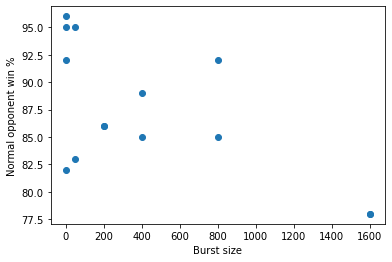

In [24]:
plt.scatter(1 + df['config/_burst_size'], 100 * df['opponent_win_rate'])
plt.xlabel('Burst size')
plt.ylabel('Normal opponent win %')
#plt.xscale('log')
plt.show()

updating: videos/ (stored 0%)
updating: videos/00000_fda63_00000.mp4 (deflated 1%)
updating: videos/00400_fda63_00011.mp4 (deflated 1%)
updating: videos/00400_fda63_00004.mp4 (deflated 1%)
updating: videos/00000_fda63_00007.mp4 (deflated 1%)
updating: videos/01600_fda63_00013.mp4 (deflated 1%)
updating: videos/00001_fda63_00008.mp4 (deflated 2%)
updating: videos/00200_fda63_00003.mp4 (deflated 1%)
updating: videos/00800_fda63_00012.mp4 (deflated 1%)
updating: videos/00200_fda63_00010.mp4 (deflated 1%)
updating: videos/00050_fda63_00002.mp4 (deflated 2%)
updating: videos/01600_fda63_00006.mp4 (deflated 2%)
updating: videos/00050_fda63_00009.mp4 (deflated 1%)
updating: videos/00001_fda63_00001.mp4 (deflated 1%)
updating: videos/00800_fda63_00005.mp4 (deflated 1%)


/scratch/sergei/better-adversarial-defenses/videos.zip

In [45]:
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
import os
from IPython.display import display, FileLink
from zipfile import ZipFile
import ray
import matplotlib.colors as mcolors

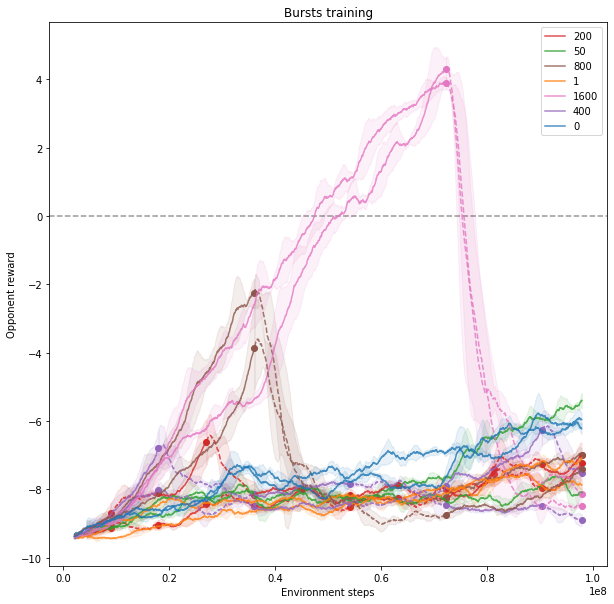

In [93]:
bss = sorted(set(df['config/_burst_size']))
cols = [x for x in mcolors.TABLEAU_COLORS]
bs_to_c = dict(list(zip(bss, cols)))
bs_seen = set()
B = 45200
roll = 50

plt.figure(figsize=(10, 10))
plt.axhline(0, c='black', ls='--', alpha=0.4)
for _, row in df.iterrows():

    
    bs = row['config/_burst_size']
    
    ys = analysis.trial_dataframes[row.logdir]['policy_reward_mean/player_1']
    ys = pd.Series(ys).rolling(roll).mean()
    ys_std = pd.Series(ys).rolling(roll).std()
    xs = np.array(range(len(ys))) * B
    
    if bs > 50:
        p = 0
        iteration = 0
        old_iteration = 0
        while iteration <= row.iterations_since_restore:
            #plt.axvline(iteration * B, ls='--', alpha=0.1)
            iteration += bs
            p = 1 - p
            if iteration:
                xs_ = xs[old_iteration:iteration]
                ys_ = ys[old_iteration:iteration]
                ys_std_ = ys_std[old_iteration:iteration]
                label = bs not in bs_seen
                ls = '--' if p == 0 else '-'
                plt.plot(xs_, ys_, color=bs_to_c[bs], label=bs if label else None, ls=ls, alpha=0.8)
                plt.fill_between(xs_, ys_ - 3 * ys_std_, ys_ + 3 * ys_std_, alpha=0.1, color=bs_to_c[bs])
                plt.scatter(xs_[-1:], ys_[-1:], color=bs_to_c[bs])
                bs_seen.add(bs)
            old_iteration = iteration
            #plt.plot(xs, ys, label=bs)
    else:
        label = bs not in bs_seen
        plt.plot(xs, ys, label=bs if label else None, c=bs_to_c[bs], alpha=0.8)
        plt.fill_between(xs, ys - 3 * ys_std, ys + 3 * ys_std, alpha=0.1, color=bs_to_c[bs])
        bs_seen.add(bs)
plt.title('Bursts training')
plt.xlabel('Environment steps')
plt.ylabel('Opponent reward')
plt.legend()
plt.show()

- same color for every burst size
- different line styles for victim/opponent

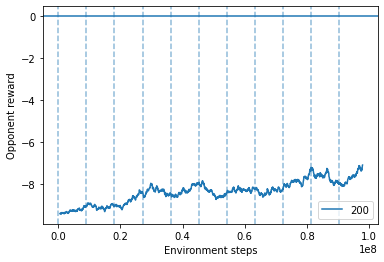

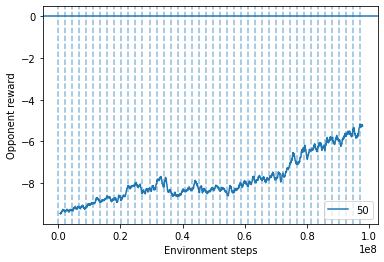

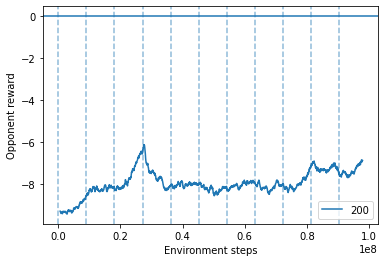

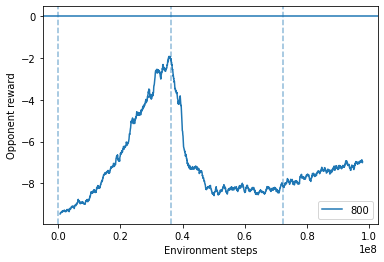

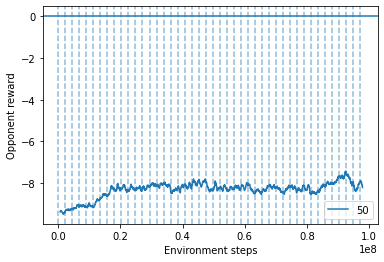

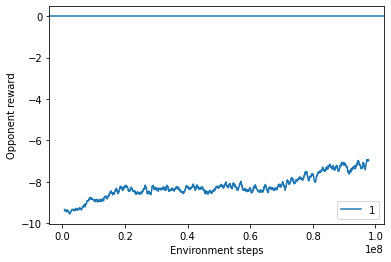

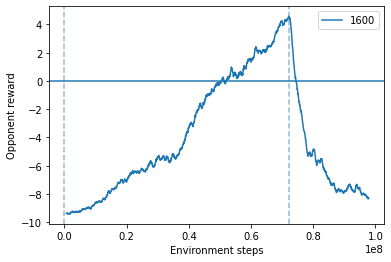

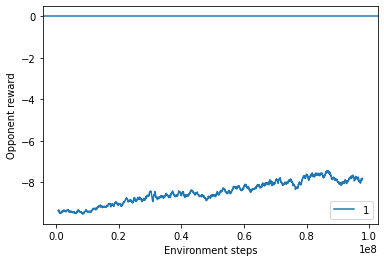

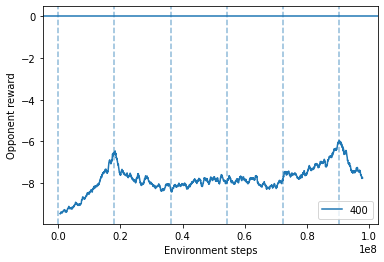

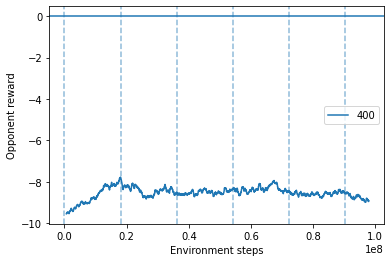

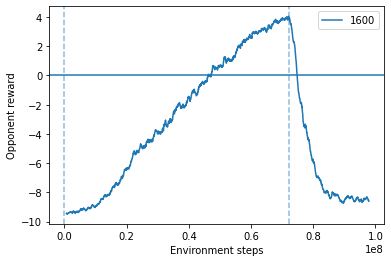

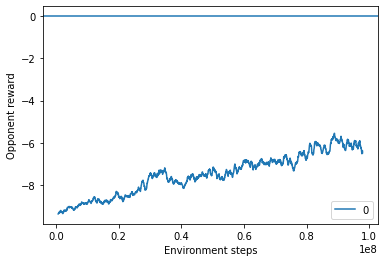

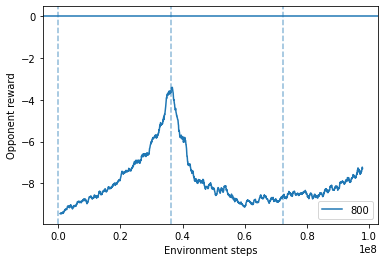

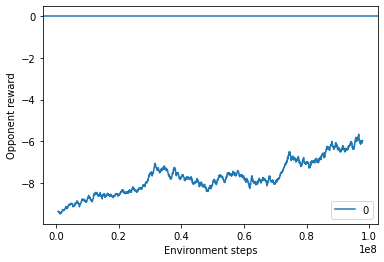

In [40]:
for _, row in df.iterrows():
    plt.figure()
    plt.axhline(0)

    iteration = 0
    bs = row['config/_burst_size']
    if bs > 4:
        while iteration <= row.iterations_since_restore:
            plt.axvline(iteration * 45200, ls='--', alpha=0.5)
            iteration += bs
    
    ys = analysis.trial_dataframes[row.logdir]['policy_reward_mean/player_1']
    ys = pd.Series(ys).rolling(15).mean()
    xs = np.array(range(len(ys))) * 45200
    plt.plot(xs, ys, label=bs)
    plt.xlabel('Environment steps')
    plt.ylabel('Opponent reward')
    plt.legend()
    plt.show()

In [64]:
checkpoint = df_best.checkpoint_rllib.iloc[-1]
checkpoint

'/home/sergei/ray_results/PPO_multicomp_2020-08-18_17-58-247iv45knf/checkpoint_398/checkpoint-398'

In [75]:
!python make_video.py --checkpoint {checkpoint} --no_video=True --steps 50 --load_normal=True

Args: Namespace(checkpoint='/home/sergei/ray_results/PPO_multicomp_2020-08-18_17-58-247iv45knf/checkpoint_398/checkpoint-398', load_normal=True, no_video=True, steps=50)
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Config {'env': 'multicomp', 'env_config': {'with_video': False, 'env_name': 'multicomp/YouShallNotPassHumans-v0'}, 'multiagent': {'policies_to_train': [], 'policies': {'player_1': (<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>, Box(380,), Box(17,), {'model': {'use_lstm': False, 'fcnet_hiddens': [64, 64], 'f

In [77]:
!export DISPLAY=:0; python make_video.py --checkpoint {checkpoint} --steps 2 --load_normal=True

Args: Namespace(checkpoint='/home/sergei/ray_results/PPO_multicomp_2020-08-18_17-58-247iv45knf/checkpoint_398/checkpoint-398', load_normal=True, no_video=False, steps=2)
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
GLFW error: 65544, desc: b'X11: RandR gamma ramp support seems broken'
Config {'env': 'multicomp', 'env_config': {'with_video': True, 'env_name': 'multicomp/YouShallNotPassHumans-v0'}, 'multiagent': {'policies_to_train': [], 'policies': {'player_1': (<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>, Box(380,),

In [78]:
#video = _
video = "video-20200818-185818-731223a8-e1bf-11ea-b2fb-e0d55e6af99c/video.000000.mp4"

In [79]:
from IPython.display import display, FileLink

local_file = FileLink(video, result_html_prefix="Click here to download: ")
display(local_file)

/scratch/sergei/better-adversarial-defenses/video-20200818-185818-731223a8-e1bf-11ea-b2fb-e0d55e6af99c/video.000000.mp4

In [80]:
from IPython.display import HTML

HTML(f"""
    <video alt="test" controls>
        <source src="{video}" type="video/mp4">
    </video>
""")
